In [12]:
# %matplotlib ipympl
import numpy as np
import matplotlib.pyplot as plt
#from impedance.preprocessing import readGamry



# Z_exp = open("Exp-data.DTA")
# print(Z_exp.read())

# f,Z_exp2= readGamry("1PVDF_K_0_0131_top16mm_A.DTA")
# print(Z_exp2)
# print(f)


filename = "Trial-5mm-30th-1.DTA"

with open(filename, 'r', encoding='ISO-8859-1') as input_file:
        lines = input_file.readlines()
        
for count,line in enumerate(lines):
    if "ZCURVE" in line:
         start_line = count+3
raw_data = lines[start_line:]

freq_exp, ReZ_exp, ImZ_exp =[], [], []

for line in raw_data:
        # line = line.replace(",", ".")
        each_line = line.split()
        freq_exp.append(float(each_line[2]))
        ReZ_exp.append(float(each_line[3]))
        ImZ_exp.append(float(each_line[4]))
num_freq =44
freq_exp =np.array(freq_exp[:num_freq])  
ReZ_exp =np.array(ReZ_exp[:num_freq]) 
ImZ_exp =np.array(ImZ_exp[:num_freq])    
print(freq_exp)  
#print(ReZ_exp) 

[2.000156e+05 1.589531e+05 1.262344e+05 1.002656e+05 7.964063e+04
 6.332812e+04 5.029688e+04 3.998437e+04 3.173438e+04 2.526563e+04
 2.001562e+04 1.589062e+04 1.270313e+04 1.007813e+04 8.015625e+03
 6.328125e+03 5.009191e+03 3.998162e+03 3.170956e+03 2.527573e+03
 2.015625e+03 1.577524e+03 1.265625e+03 9.982640e+02 7.968750e+02
 6.277902e+02 5.055147e+02 3.979953e+02 3.155048e+02 2.524038e+02
 1.986229e+02 1.583615e+02 1.255580e+02 1.004464e+02 7.990057e+01
 6.334460e+01 5.022321e+01 3.842213e+01 3.125000e+01 2.493351e+01
 1.986229e+01 1.605308e+01 1.240079e+01 9.931140e+00]


In [13]:
# RQ initialization

R_f = 10
Q_f = 3e-5
alp = 0.8

# freq =np.logspace(5,1,10);
# omega = 2*np.pi*freq
# Impedance_rq = R_f + 1/(((1j*omega)**alp)*Q_f)
# print(Impedance_rq)

Chi_square is 0.0577
2.0989 7e-06 0.7853


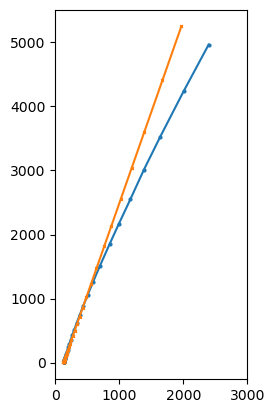

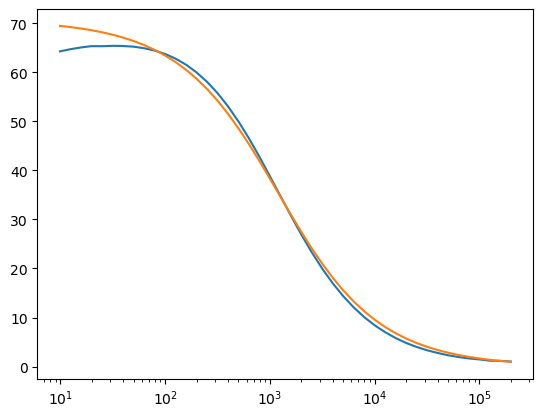

In [14]:
#RQ fitting
from scipy.optimize import minimize, NonlinearConstraint

t= dist = 120*1e-6
K_pure =0.1
rb=5e-3/2
rtop=16e-3/2

def objective(x):
    
    
    omega = 2*np.pi*freq_exp
    R_f = x[0]
    alp = x[1]
    Q_f = x[2]

    Impedance_rq = R_f + 1/(((1j*omega)**alp)*Q_f)
    # print(Impedance_rq)
    mod_weight = (np.real(Impedance_rq)**2 + np.imag(Impedance_rq)**2)
   
    unit_weight =1
    weight = mod_weight
    terms = ((np.real(Impedance_rq) - ReZ_exp)**2 +(np.imag(Impedance_rq) - ImZ_exp)**2)/weight
    Chi_square = sum(terms)
    return Chi_square

# def constraint(x):
#     return x[0]**2 + x[1]**2 - 1

# initial guess
x0 = [1, 1, 1]

# define the bounds for the variables
bounds = ((0, 1000), (0, 1),(0, 10))

# define the nonlinear constraint
# nonlinear_constraint = NonlinearConstraint(constraint, -np.inf, 0)

# minimize the objective function subject to the nonlinear constraint
res = minimize(objective,x0,method='trust-constr', constraints=[], bounds=bounds)
# res = curve_fit(objective,x0, method='trust-constr', constraints=[], bounds=bounds)

#print(f"{res.fun:.4f}")

Chi_square_min = res.fun
print(f"Chi_square is {Chi_square_min:.4f}")
R_fit = round(res.x[0],4)
alp_fit = round(res.x[1],4)
Q_fit = round(res.x[2],6)
omega = 2*np.pi*freq_exp
Impedance_rq_fit= R_fit + 1/(((1j*omega)**alp_fit)*Q_fit)
Nm_fit = K_pure*R_fit*np.pi*(rb**2)/t
print(round(Nm_fit,4),Q_fit,alp_fit)
# mod_weight = np.real(Impedance_rq_fit)**2 + np.imag(Impedance_rq_fit)**2
# plt.semilogx(freq_exp,mod_weight)
# plt.show()

#print(f"The minimum value of the objective function is {res.fun:.4f} at x = {res.x}.")


####Plots
plt.plot(ReZ_exp,-ImZ_exp,'o-',ms=2)
plt.plot(np.real(Impedance_rq_fit),-np.imag(Impedance_rq_fit),'x-',ms=2)
plt.xlim(0,3000)
# plt.legend("Exp","fit")
plt.gca().set_aspect('equal')
plt.show()

#Phase angle plot
plt.semilogx(freq_exp,57.29*np.arctan(-ImZ_exp/ReZ_exp))
plt.semilogx(freq_exp,57.29*np.arctan(-np.imag(Impedance_rq_fit)/np.real(Impedance_rq_fit)))
plt.show()


In [55]:
# To get solutions of characteristic equations
import scipy
from sympy import *

lam = Symbol("lambda")
sol =0  
NN = 10 # No of solutions of the equation
solutions = [0]  # First solution

for i in range(1,NN):
    sol = nsolve(besselj(1,lam),sol+3,prec= 5)
    solutions.append(sol)

Lam = np.array(solutions)
print(Lam)

[0 3.8317 7.0156 10.173 13.324 16.471 19.616 22.760 25.904 29.047]


In [77]:
#Maths fitting
from scipy.optimize import minimize, NonlinearConstraint
from scipy.special import jv

def objective(x):
    
    t= dist = 120*1e-6
    K_pure =0.131
    rb=16e-3/2
    rtop=16e-3/2
    
    phis_bottom = 1
    phis_top = 0
    
    # omega = 2*np.pi*freq_exp
    # Nm_f = round(x[0],4)
    # alp = round(x[1],4)
    # C_f = round(x[2]/1e5,6)
    Nm_f = x[0]
    alp = x[1]
    C_f = x[2]
    print(Nm_f, alp, C_f)
    Keff = K_pure/Nm_f
    xi=rtop/rb
    yt = t/rb

    #Maths impedance calculation

    #Frequency independent terms
    # BC3 term
    L_A = np.zeros((NN,NN),dtype =np.complex_)
    #print(L_A)
    m=0
    for m in range(0,NN):
        L_A[m,m] = Keff*(jv(0,float(Lam[m]))**2)/(2*rb)
    # print(L_A)

    #BC4 term
    LL_A = np.zeros((NN,NN),dtype =np.complex_)
    LL_B = np.zeros((NN,NN),dtype =np.complex_)

    m=0
    for m in range(0,NN):
        LL_A[m,m] = Keff*cosh(Lam[m]*yt)*(jv(0,float(Lam[m]))**2)/(2*rb)
        LL_B[m,m] = Keff*Lam[m]*sinh(Lam[m]*yt)*(jv(0,float(Lam[m]))**2)/(2*rb)

    # print(LL_A)
    # print(LL_B)

    #Freq dependant terms
    fr =0
    Impedance_math = np.zeros(len(freq_exp),dtype=np.complex_)
    for  fr in range(len(freq_exp)):  
        omega = 2*np.pi*freq_exp[fr]
        S = (1j*omega)**alp
        #print(S)
        b = np.zeros((NN,NN),dtype=np.complex_)
        m=0
        for m in range(0,NN):
            b[m,m] = C_f*S*(jv(0,float(Lam[m]))**2)/2
        #print(b)
            
        R= np.zeros((NN,1),dtype=np.complex_)
        R[0] = C_f*S*phis_bottom/2
        #print(R)

        #BC4 terms
        PP_A = np.zeros((NN,NN),dtype=np.complex_)
        PP_B = np.zeros((NN,NN),dtype=np.complex_ )
        m=0
        for m in range(0,NN):
            if m==0:
                PP_A[0,0] = C_f*S*(xi**2)*yt/2
                
                PP_B[0,0] = C_f*S*(xi**2)/2
            else:
                
                PP_A[m,0] = C_f*S*yt*xi*jv(1,float(Lam[m])*xi)/Lam[m]
                PP_B[m,0] = C_f*S*xi*jv(1,float(Lam[m])*xi)/Lam[m]
        #print(PP_A)
        #For other elements of PP matrix
        m=n=0
        for m in range(0,NN):
            for n in range(1,NN):
                if m==n:
                    PP_A[m,n] = C_f*S*(sinh(Lam[n]*yt)/Lam[n])*((xi**2)/2)*jv(0,float(Lam[m])*xi)**2 + jv(1,float(Lam[m])*xi)**2
                    PP_B[m,n] = C_f*S*(cosh(Lam[n]*yt))*((xi**2)/2)*jv(0,float(Lam[m])*xi)**2 + jv(1,float(Lam[m])*xi)**2

                else:
                    PP_A[m,n] = C_f*S*(sinh(Lam[n]*yt)/Lam[n])*(xi/(Lam[m]**2 - Lam[n]**2))*(jv(1,float(Lam[m])*xi)*jv(0,float(Lam[n])*xi)*Lam[m] - jv(0,float(Lam[m])*xi)*jv(1,float(Lam[n])*xi)*Lam[n])
                    PP_B[m,n] = C_f*S*cosh(Lam[n]*yt)*(xi/(Lam[m]**2 - Lam[n]**2))*(jv(1,float(Lam[m])*xi)*jv(0,float(Lam[n])*xi)*Lam[m] - jv(0,float(Lam[m])*xi)*jv(1,float(Lam[n])*xi)*Lam[n])  

        
        #print(PP_B)  
        Alpha = LL_A + PP_A
        Delta = LL_B + PP_B
        #print((Alpha))
        Gamma = np.linalg.inv(Alpha)*Delta
        B = np.linalg.inv(b + L_A*Gamma)*R
        shi = -Gamma*B
        # print(shi)
        # print(B)
        Impedance_math[fr] = (phis_bottom-phis_top)/(-np.pi*Keff*shi[0,0]*rb)
        #print(Impedance_math)

        # print(Impedance_rq)
    mod_weight = (np.real(Impedance_math)**2 + np.imag(Impedance_math)**2)
    
    unit_weight =1
    weight = mod_weight
    terms = ((np.real(Impedance_math) - ReZ_exp)**2 +(abs(np.imag(Impedance_math)) - abs(ImZ_exp))**2)/weight
    # Chi_square = round(sum(terms),5)
    Chi_square = sum(terms)
    print(Chi_square)
    return Chi_square

def constraint(x):
    x[0]-1>=0
    x[0]-10<=0

    x[1]>=0
    x[1]-1<=0
    
    x[2]>=0
    x[2]<=10

# initial guess
#x0 = [2.0295,    0.8576,    0.3343]
x0 = [5,    0.9,    1]
# define the bounds for the variables
bounds = ((1, 10), (0, 1),(0, 1e7))

# define the nonlinear constraint
cons = {'type':'ineq','fun':constraint}
# minimize the objective function subject to the nonlinear constraint
res = minimize(objective,x0,method='trust-constr', constraints=[cons])
# res = curve_fit(objective,x0, method='trust-constr', constraints=[], bounds=bounds)

#print(f"{res.fun:.4f}")
Chi_square_min = res.fun
print(f"Chi_square is {Chi_square_min:.4f}")
Nm_math_fit = round(res.x[0],4)
alp_math_fit = round(res.x[1],6)
C_math_fit = round(res.x[2]/1e5,6)

print(Nm_math_fit,alp_math_fit,C_math_fit)





c:\Users\Admin\anaconda3\lib\site-packages\scipy\optimize\_minimize.py:565: RuntimeWarning: Method trust-exact cannot handle constraints.
  warn('Method %s cannot handle constraints.' % method,


ValueError: Jacobian is required for trust region exact minimization.

In [48]:
#Maths impedance calculation --output
Impedance_math =[]
t= dist = 120*1e-6
K_pure =0.131
rb=16e-3/2
rtop=16e-3/2
phis_bottom = 1
phis_top = 0


# [Nm_f, alp, C_f] =[Nm_math_fit,alp_math_fit,C_math_fit]
[Nm_f, alp, C_f] =[2.03, 0.8579, 0.3346 ]
print(Nm_f, alp, C_f)
# Nm_f = 2.0295
# alp =  0.8576
# C_f = 0.3343
    
Keff = K_pure/Nm_f
# print(Keff)
xi=rtop/rb
yt = t/rb

#Frequency independent terms
# BC3 term
L_A = np.zeros((NN,NN),dtype =np.complex_)

m=0
for m in range(0,NN):
    L_A[m,m] = Keff*(jv(0,float(Lam[m]))**2)/(2*rb)
#print(L_A)

#BC4 term
LL_A = np.zeros((NN,NN),dtype =np.complex_)
LL_B = np.zeros((NN,NN),dtype =np.complex_)

m=0
for m in range(0,NN):
    LL_A[m,m] = Keff*cosh(Lam[m]*yt)*(jv(0,float(Lam[m]))**2)/(2*rb)
    LL_B[m,m] = Keff*Lam[m]*sinh(Lam[m]*yt)*(jv(0,float(Lam[m]))**2)/(2*rb)

# print(LL_A)
# print(LL_B)

#Freq dependant terms

fr =0
for  fr in range(len(freq_exp)):  
    omega = 2*np.pi*freq_exp[fr]
    S = (1j*omega)**alp
    print(freq_exp[fr])
    b = np.zeros((NN,NN),dtype=np.complex_)
    m=0
    for m in range(0,NN):
        b[m,m] = C_f*S*(jv(0,float(Lam[m]))**2)/2
    #print(b)
        
    R= np.zeros((NN,1),dtype=np.complex_)
    R[0] = C_f*S*phis_bottom/2
    #print(R)

    #BC4 terms
    PP_A = np.zeros((NN,NN),dtype=np.complex_)
    PP_B = np.zeros((NN,NN),dtype=np.complex_ )
    m=0
    for m in range(0,NN):
        if m==0:
            PP_A[0,0] = C_f*S*(xi**2)*yt/2
            
            PP_B[0,0] = C_f*S*(xi**2)/2
        else:
            
            PP_A[m,0] = C_f*S*yt*xi*jv(1,float(Lam[m])*xi)/Lam[m]
            PP_B[m,0] = C_f*S*xi*jv(1,float(Lam[m])*xi)/Lam[m]
    #print(PP_A)
    #For other elements of PP matrix
    m=n=0
    for m in range(0,NN):
        for n in range(1,NN):
            if m==n:
                PP_A[m,n] = C_f*S*(sinh(Lam[n]*yt)/Lam[n])*((xi**2)/2)*jv(0,float(Lam[m])*xi)**2 + jv(1,float(Lam[m])*xi)**2
                PP_B[m,n] = C_f*S*(cosh(Lam[n]*yt))*((xi**2)/2)*jv(0,float(Lam[m])*xi)**2 + jv(1,float(Lam[m])*xi)**2

            else:
                PP_A[m,n] = C_f*S*(sinh(Lam[n]*yt)/Lam[n])*(xi/(Lam[m]**2 - Lam[n]**2))*(jv(1,float(Lam[m])*xi)*jv(0,float(Lam[n])*xi)*Lam[m] - jv(0,float(Lam[m])*xi)*jv(1,float(Lam[n])*xi)*Lam[n])
                PP_B[m,n] = C_f*S*cosh(Lam[n]*yt)*(xi/(Lam[m]**2 - Lam[n]**2))*(jv(1,float(Lam[m])*xi)*jv(0,float(Lam[n])*xi)*Lam[m] - jv(0,float(Lam[m])*xi)*jv(1,float(Lam[n])*xi)*Lam[n])  

    
    #print(PP_B)  
    Alpha = LL_A + PP_A
    Delta = LL_B + PP_B
    #print((Alpha))
    Gamma = np.linalg.inv(Alpha)*Delta
    B = np.linalg.inv(b + L_A*Gamma)*R
    shi = -Gamma*B
    # print(shi)
    # print(B)
    Imped = (phis_bottom-phis_top)/(-np.pi*Keff*shi[0,0]*rb)
    print(Imped)
    Impedance_math.append(Imped)
    
    


# mod_weight = np.real(Impedance_rq_fit)**2 + np.imag(Impedance_rq_fit)**2
# plt.semilogx(freq_exp,mod_weight)
# plt.show()
#print(f"The minimum value of the objective function is {res.fun:.4f} at x = {res.x}.")
#####Plots
plt.plot(ReZ_exp,-ImZ_exp,'o-',ms=2)
plt.plot(np.real(Impedance_math),-np.imag(Impedance_math),'x-',ms=2)
plt.xlim(0,500)
plt.ylim(0,1000)
# plt.legend("Exp","fit")
#plt.gca().set_aspect('equal')
plt.show()
#Phase angle plot
plt.semilogx(freq_exp,57.29*np.arctan(-ImZ_exp/ReZ_exp))
plt.semilogx(freq_exp,57.29*np.arctan(-np.imag(Impedance_math)/np.real(Impedance_math)))
plt.show()


2.03 0.8579 0.3346
200015.6
(9.287127377674594-0.16971611514588208j)
158953.1
(9.29552207863339-0.20669839223547376j)
126234.4
(9.305779510068376-0.25188680018689913j)
100265.6
(9.3182704041391-0.30691457400364586j)
79640.63


KeyboardInterrupt: 

In [8]:
#Maths impedance calculation
from scipy.special import jv

t= dist = 120*1e-6
K_pure =0.131
rb=16e-3/2
rtop=16e-3/2
phis_bottom = 1
phis_top = 0

freq =np.array([200*1e3])
[Nm_f, alp, C_f] =[5.3958,  0.849252,0.0001]
#print(freq)
# Nm_f = 2.0295
# alp =  0.8576
# C_f = 0.3343
    
Keff = K_pure/Nm_f
# print(Keff)
xi=rtop/rb
yt = t/rb

#Frequency independent terms
# BC3 term
L_A = np.zeros((NN,NN),dtype =np.complex_)

m=0
for m in range(0,NN):
    L_A[m,m] = Keff*(jv(0,float(Lam[m]))**2)/(2*rb)
#print(L_A)

#BC4 term
LL_A = np.zeros((NN,NN),dtype =np.complex_)
LL_B = np.zeros((NN,NN),dtype =np.complex_)

m=0
for m in range(0,NN):
    LL_A[m,m] = Keff*cosh(Lam[m]*yt)*(jv(0,float(Lam[m]))**2)/(2*rb)
    LL_B[m,m] = Keff*Lam[m]*sinh(Lam[m]*yt)*(jv(0,float(Lam[m]))**2)/(2*rb)

# print(LL_A)
# print(LL_B)

#Freq dependant terms
fr =0
for  fr in range(len(freq)):  
    omega = 2*np.pi*freq[fr]
    S = (1j*omega)**alp
    #print(S)
    b = np.zeros((NN,NN),dtype=np.complex_)
    m=0
    for m in range(0,NN):
        b[m,m] = C_f*S*(jv(0,float(Lam[m]))**2)/2
    #print(b)
        
    R= np.zeros((NN,1),dtype=np.complex_)
    R[0] = C_f*S*phis_bottom/2
    #print(R)

    #BC4 terms
    PP_A = np.zeros((NN,NN),dtype=np.complex_)
    PP_B = np.zeros((NN,NN),dtype=np.complex_ )
    m=0
    for m in range(0,NN):
        if m==0:
            PP_A[0,0] = C_f*S*(xi**2)*yt/2
            
            PP_B[0,0] = C_f*S*(xi**2)/2
        else:
            
            PP_A[m,0] = C_f*S*yt*xi*jv(1,float(Lam[m])*xi)/Lam[m]
            PP_B[m,0] = C_f*S*xi*jv(1,float(Lam[m])*xi)/Lam[m]
    #print(PP_A)
    #For other elements of PP matrix
    m=n=0
    for m in range(0,NN):
        for n in range(1,NN):
            if m==n:
                PP_A[m,n] = C_f*S*(sinh(Lam[n]*yt)/Lam[n])*((xi**2)/2)*jv(0,float(Lam[m])*xi)**2 + jv(1,float(Lam[m])*xi)**2
                PP_B[m,n] = C_f*S*(cosh(Lam[n]*yt))*((xi**2)/2)*jv(0,float(Lam[m])*xi)**2 + jv(1,float(Lam[m])*xi)**2

            else:
                PP_A[m,n] = C_f*S*(sinh(Lam[n]*yt)/Lam[n])*(xi/(Lam[m]**2 - Lam[n]**2))*(jv(1,float(Lam[m])*xi)*jv(0,float(Lam[n])*xi)*Lam[m] - jv(0,float(Lam[m])*xi)*jv(1,float(Lam[n])*xi)*Lam[n])
                PP_B[m,n] = C_f*S*cosh(Lam[n]*yt)*(xi/(Lam[m]**2 - Lam[n]**2))*(jv(1,float(Lam[m])*xi)*jv(0,float(Lam[n])*xi)*Lam[m] - jv(0,float(Lam[m])*xi)*jv(1,float(Lam[n])*xi)*Lam[n])  

    
    #print(PP_B)  
    Alpha = LL_A + PP_A
    Delta = LL_B + PP_B
    #print((Alpha))
    Gamma = np.linalg.inv(Alpha)*Delta
    B = np.linalg.inv(b + L_A*Gamma)*R
    shi = -Gamma*B
    # print(shi)
    # print(B)
    Impedance_math = (phis_bottom-phis_top)/(-np.pi*Keff*shi[0,0]*rb)
    print(Impedance_math)


(178.83804245615997-639.2086827059702j)


In [9]:
# A=np.zeros((3,3),dtype=np.complex_)
# B=np.zeros(1)
# print(A)
# A[0,0]= C_f*S*(xi**2)*yt/2
# print(A)
# B= C_f*S*(xi**2)*yt/2
# print(B)

(0.0, 500.0)

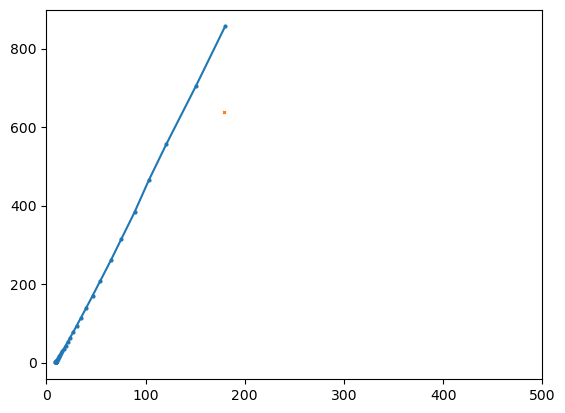

In [10]:
plt.plot(ReZ_exp,-ImZ_exp,'o-',ms=2)
plt.plot(np.real(Impedance_math),-np.imag(Impedance_math),'x-',ms=2)
plt.xlim(0,500)

[]
